# Mapping mouse coronal snRNA-seq cell type to 10X Visium

## Contents:
* [Loading packages](#Loading_packages)
* [Loading Visium data](#Loading_Visium)
* [Load cell type expression signatures programmes](#Loading_signatures)
* [Run scvi-sterescope](#scvi-sterescope)
* [Region clustering cell densities](#region_clustering)
* [Export regions for import to 10X Loupe Browser](#loupe)
* [Run diffusion maps](#diffmap)
* [Run factorisation to find groups of cell types with similar location](#factorisation)


### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
import sys, ast, os
import time
import pickle
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import os
from plotnine import *
import matplotlib.pyplot as plt 
import matplotlib
data_type = 'float32'
os.environ["THEANO_FLAGS"] = 'device=cuda0,floatX=' + data_type + ',force_device=True'
# /nfs/team283/vk7/software/miniconda3farm5/envs/cellpymc/bin/pip install git+https://github.com/vitkl/cell2location.git
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location_dev/')

import cell2location
#import pycell2location.models as c2l

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
from matplotlib import rcParams
import seaborn as sns

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/nfs/users/nfs_v/vk7/.local/lib/python3.7/site-packages/theano/gpuarray/dnn.py:184: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
Using cuDNN version 7605 on context None
Mapped name None to device cuda0: Tesla V100-SXM2-32GB (0000:62:00.0)


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

## Loading Visium data <a class="anchor" id="Loading_Visium"></a>

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [2]:
# read cell2location model results
c2l_results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/results/visium_human_ln/'
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/lymph_nodes_analysis/'

run_name = 'CoLocationModelNB4V2_34clusters_4039locations_10241genes_input_inferred_V4_batch1024_l2_0001_n_comb50_5_cps5_fpc3_alpha001'

sp_data_file = c2l_results_folder + 'std_model/'+run_name+'/sp_with_clusters.h5ad'
adata_vis = anndata.read(sp_data_file)
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


### Load cell type expression signatures programmes <a class="anchor" id="Loading_signatures"></a>

In [3]:
reg_mod_name = 'RegressionNBV4Torch_57covariates_73260cells_10237genes'
reg_path = f'{c2l_results_folder}regression_model/{reg_mod_name}/'

adata_snrna_raw = sc.read(f'{reg_path}sc.h5ad')
#r = pickle.load(file = open(f'{reg_path}model_.p', "rb"))
#reg_mod = r['mod']

In [4]:
# export inferred averages in each cluster
inf_aver = adata_snrna_raw.var.copy()
inf_aver = inf_aver.loc[:, [f'mean_cov_effect_Subset_{i}' for i in adata_snrna_raw.obs['Subset'].unique()]]
from re import sub
inf_aver.columns = [sub(f'mean_cov_effect_Subset_{i}', '', i) for i in adata_snrna_raw.obs['Subset'].unique()]
inf_aver = inf_aver.iloc[:, inf_aver.columns.argsort()]

# scale up by average sample scaling factor
inf_aver = inf_aver * adata_snrna_raw.uns['regression_mod']['post_sample_means']['sample_scaling'].mean()

In [5]:
inf_aver

,B_Cycling,B_GC_DZ,B_GC_LZ,B_GC_prePB,B_IFN,B_activated,B_mem,B_naive,B_plasma,B_preGC,...,T_CD4+_TfH,T_CD4+_TfH_GC,T_CD4+_naive,T_CD8+_CD161+,T_CD8+_cytotoxic,T_CD8+_naive,T_TIM3+,T_TfR,T_Treg,VSMC
NOC2L,0.389986,0.214435,0.256271,2.956784e-01,1.257083e-01,0.147153,0.151172,0.122755,0.230796,3.209226e-01,...,0.111511,0.126056,0.166565,0.103764,0.094503,0.202703,0.310293,0.164446,0.131172,1.553225e-01
HES4,0.001658,0.000012,0.000026,1.760481e-02,2.063625e-02,0.009338,0.027511,0.005316,0.000022,1.540930e-02,...,0.040316,0.031491,0.060974,0.014621,0.004839,0.018781,0.145339,0.304292,0.057148,1.146690e+00
ISG15,0.305257,0.138387,0.194006,3.523145e-01,4.158280e+00,0.075383,0.180887,0.068329,0.278930,6.063494e-02,...,0.176523,0.345447,0.309671,0.223379,0.255122,0.380937,1.813222,0.579268,0.279670,2.518890e-01
TNFRSF18,0.016858,0.000055,0.048861,2.888634e-02,2.197197e-03,0.003020,0.002943,0.000163,0.117772,1.235234e-01,...,0.012353,0.309472,0.001328,0.049863,0.009768,0.000078,0.313490,0.922481,0.387692,1.563772e-09
TNFRSF4,0.005551,0.000005,0.002945,7.722527e-03,5.199437e-03,0.000588,0.002372,0.000113,0.066400,3.887395e-02,...,0.125807,0.636628,0.028578,0.043257,0.011839,0.000788,0.511069,1.753242,0.793970,1.614110e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IGL_VDJsum,9.948876,7.563540,3.652213,9.407078e+00,4.041258e+00,2.961928,3.139248,2.823470,109.727700,3.701239e+00,...,0.008561,0.015481,0.017801,0.025344,0.033933,0.004070,0.039067,0.027824,0.010213,1.616372e-02
TCRA_VDJsum,0.031178,0.001534,0.011304,5.098840e-02,4.094036e-10,0.000387,0.000389,0.000087,0.062889,7.492414e-04,...,2.594676,2.544148,2.547520,2.249395,2.027942,2.204234,4.086637,2.899816,3.444732,2.479343e-01
TCRB_VDJsum,0.051580,0.000504,0.002989,3.281814e-04,2.296285e-03,0.000485,0.002994,0.000680,0.106378,3.955359e-04,...,3.988787,6.722402,3.845822,2.744595,3.262480,3.290963,7.399317,7.432308,4.821861,1.205301e-01
TCRD_VDJsum,0.000339,0.001759,0.002099,9.781692e-10,5.895333e-10,0.000099,0.000496,0.000015,0.000500,3.789579e-10,...,0.041513,0.019695,0.034700,0.198152,0.095711,0.058952,0.015891,0.017350,0.028833,1.754361e-09


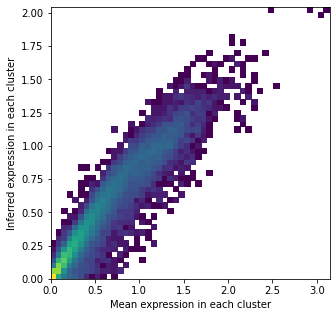

In [7]:
# compute mean expression of each gene in each cluster
aver = cell2location.cluster_averages.cluster_averages.get_cluster_averages(adata_snrna_raw, 'Subset')
aver = aver.loc[adata_snrna_raw.var_names, inf_aver.columns]

rcParams['figure.figsize'] = 5, 5
plt.hist2d(np.log10(aver.values.flatten()+1), np.log10(inf_aver.values.flatten()+1),
           bins=50, norm=matplotlib.colors.LogNorm());
plt.xlabel('Mean expression in each cluster');
plt.ylabel('Inferred expression in each cluster');

### Run scvi-sterescope <a class="anchor" id="scvi-sterescope"></a>

In [8]:
results_folder + 'scvi_stereoscope/'

'/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/benchmarking/lymph_nodes_analysis/scvi_stereoscope/'

In [9]:
from scvi.data import register_tensor_from_anndata
from scvi.model.stereoscope import scStereoscope, stStereoscope
import scvi

rcParams['figure.figsize'] = 5, 5

In [11]:
adata_snrna_raw.raw.X.data

array([ 1.,  1., 10., ...,  1.,  5.,  4.], dtype=float32)

In [12]:
adata_snrna_raw.layers["counts"] = adata_snrna_raw.raw.X.copy()

In [14]:
scvi.data.setup_anndata(adata_snrna_raw, layer = "counts", labels_key = "Subset")

adata_snrna_raw.obs["indices"] = np.arange(adata_snrna_raw.n_obs)
register_tensor_from_anndata(adata_snrna_raw, "ind_x", "obs", "indices")

model = scStereoscope(adata_snrna_raw)
model.train(lr = 0.01, n_epochs = 1000, frequency = 1)

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["Subset"]                                               
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 73260 cells, 10237 genes, 1       
         batches, 34 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          
INFO     Training for 1000 epochs                                                            
INFO     KL warmup for 400 epochs                                                            


Output()

INFO     Training time:  7883 s. / 1000 epochs                                               


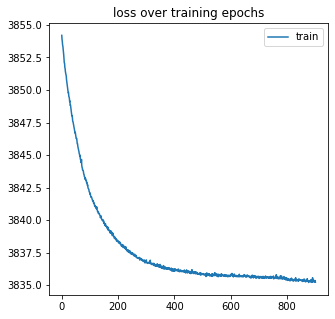

In [15]:
plt.plot(model.history["elbo_train_set"][100:], label = "train")
plt.title("loss over training epochs")
plt.legend()

In [16]:
params = model.get_params()
params[0].shape
model.save(f"{results_folder}scvi_stereoscope/scmodel_1k.pkl", overwrite = True)

- Filter genes to be the same as the scRNA-Seq data

In [22]:
adata = adata_vis.copy()
adata.var_names_make_unique()
adata_snrna_raw.var.index.isin(adata.var.index).sum(), adata_snrna_raw.shape

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(10230, (73260, 10237))

In [23]:
adata.var.index, adata_snrna_raw.var.index

(Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
        'AL627309.2', 'AL627309.4', 'AL732372.1', 'OR4F29', 'AC114498.1',
        ...
        'AC007325.2', 'BX072566.1', 'AL354822.1', 'AC023491.2', 'AC004556.1',
        'AC233755.2', 'AC233755.1', 'AC240274.1', 'AC213203.1', 'FAM231C'],
       dtype='object', length=33538),
 Index(['NOC2L', 'HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'SDF4', 'UBE2J2',
        'PUSL1', 'CPTP', 'MXRA8',
        ...
        'AC004556.1', 'AC233755.2', 'AC233755.1', 'IGH_VDJsum', 'IGK_VDJsum',
        'IGL_VDJsum', 'TCRA_VDJsum', 'TCRB_VDJsum', 'TCRD_VDJsum',
        'TCRG_VDJsum'],
       dtype='object', length=10237))

In [24]:
#intersect = np.intersect1d(adata_snrna_raw.var_names, adata.var_names)
#adata = adata[:, intersect].copy()
inter_ind = adata_snrna_raw.var.index.isin(adata.var.index)
adata = adata[:, adata_snrna_raw.var_names[inter_ind]].copy()

#mask = [x in intersect for x in adata_snrna_raw.var_names]
params = [params[0][inter_ind, :], params[1][inter_ind]]

len(adata.var_names) == params[0].shape[0]

True

In [26]:
adata.layers["counts"] = adata.X.copy()
scvi.data.setup_anndata(adata, layer = "counts")

adata.obs["indices"] = np.arange(adata.n_obs)
register_tensor_from_anndata(adata, "ind_x", "obs", "indices")

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 4039 cells, 10230 genes, 1        
         batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [27]:
spatial_model = stStereoscope(adata, params)
spatial_model.train(lr = 0.01, n_epochs = 20000, train_size = 1, frequency = 1)

INFO     Training for 20000 epochs                                                           
INFO     KL warmup for 400 epochs                                                            


Output()

INFO     Training time:  9082 s. / 20000 epochs                                              


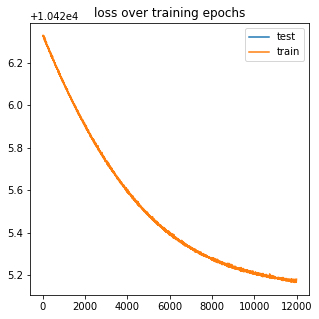

In [28]:
plt.plot(spatial_model.history["elbo_test_set"][8000:], label = "test")
plt.plot(spatial_model.history["elbo_train_set"][8000:], label = "train")
plt.title("loss over training epochs")
plt.legend()

In [29]:
adata_snrna_raw.var_names, adata.var_names

(Index(['NOC2L', 'HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'SDF4', 'UBE2J2',
        'PUSL1', 'CPTP', 'MXRA8',
        ...
        'AC004556.1', 'AC233755.2', 'AC233755.1', 'IGH_VDJsum', 'IGK_VDJsum',
        'IGL_VDJsum', 'TCRA_VDJsum', 'TCRB_VDJsum', 'TCRD_VDJsum',
        'TCRG_VDJsum'],
       dtype='object', length=10237),
 Index(['NOC2L', 'HES4', 'ISG15', 'TNFRSF18', 'TNFRSF4', 'SDF4', 'UBE2J2',
        'PUSL1', 'CPTP', 'MXRA8',
        ...
        'PCNT', 'DIP2A', 'S100B', 'PRMT2', 'AC136616.2', 'AC141272.1',
        'AL592183.1', 'AC004556.1', 'AC233755.2', 'AC233755.1'],
       dtype='object', length=10230))

In [30]:
import pandas as pd
adata.obsm["decomposition"] = pd.DataFrame(data = spatial_model.get_proportions(), index = adata.obs.index, 
                                           columns = adata_snrna_raw.uns["_scvi"]["categorical_mappings"]["_scvi_labels"]["mapping"])


In [31]:
for ct in adata.obsm["decomposition"].columns:
    adata.obs[ct] = adata.obsm["decomposition"][ct]

In [32]:
adata.write(f"{results_folder}scvi_stereoscope/sp_20k.h5ad")

... storing 'sample' as categorical


Here we visualise locations of multiple cell types at once.

In [33]:
# identify spot locations to crop near tissue
def get_crop_coord(slide):

    crop_max = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
    crop_min = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

    crop_x = [crop_min[0]-50, crop_max[0]+50]
    crop_y = [crop_min[1]-20, crop_max[1]+0]

    return crop_x, crop_y

In [34]:
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

## Region clustering cell densities <a class="anchor" id="region_clustering"></a>

We find regions by clustering spots based on inferred molecule contributions of each cell type. We use leiden clustering that incorporates both the similarity of spots in cell locations and in their proximity, by including both when computing the KNN graph. Results are saved in `adata_vis.obs['leiden']`.

In [35]:
adata_vis = adata.copy()

sample_type = 'stereoscope'
adata_vis.obsm["stereoscope"] = adata_vis.obsm["decomposition"].values

# compute KNN using the cell2location output
sc.pp.neighbors(adata_vis, use_rep=sample_type,
                n_neighbors = 38)

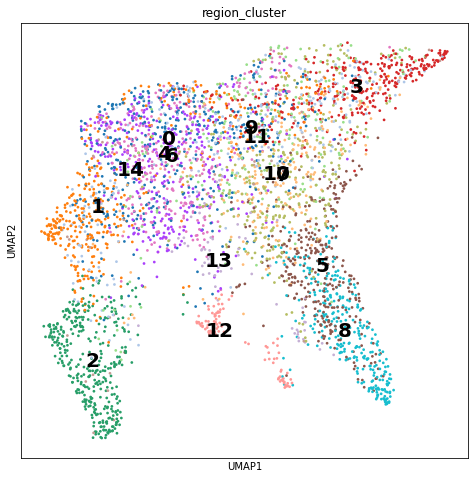

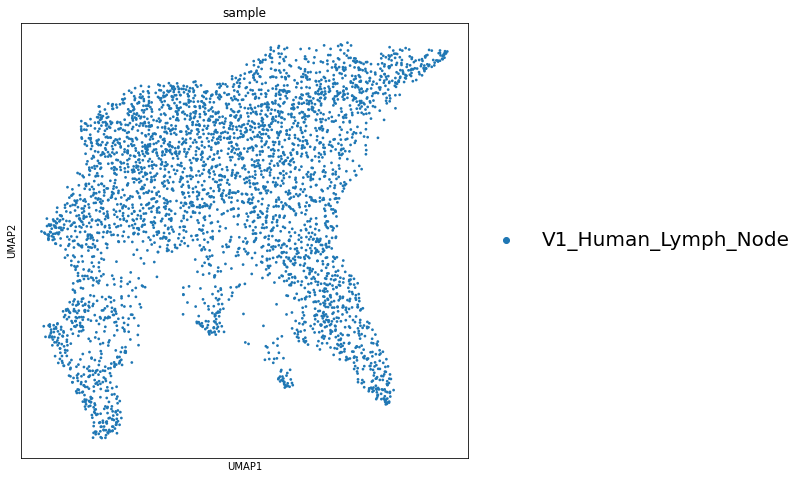

In [36]:
sc.tl.umap(adata_vis, min_dist = 0.3, spread = 1)

rcParams['figure.figsize'] = 8, 8
rcParams["axes.facecolor"] = "white"
sc.pl.umap(adata_vis, color=['region_cluster'], size=30,
           color_map = 'RdPu', ncols = 2, legend_loc='on data',
           legend_fontsize=20)
sc.pl.umap(adata_vis, color=['sample'], size=30,
           color_map = 'RdPu', ncols = 2, #legend_loc='on data',
           legend_fontsize=20)

Modules and their versions used for this analysis

In [37]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass

ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.18.1
IPython.core.release 7.18.1
logging 0.5.1.2
zlib 1.0
traitlets 5.0.4
traitlets._version 5.0.4
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
pygments 2.7.1
pexpect 4.8.0
ptyprocess 0.6.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
prompt_toolkit 3.0.7
wcwidth 0.2.5
jedi 0.17.2
parso 0.7.1
colorama 0.4.3
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 19.0.2
zmq.backend.cython 40302
zmq.backend.cython.constants 40302
zmq.sugar 19.0.2
zmq.sugar.constants 40302
zmq.sugar.version 19.0.2
jupyter_core 4.6.3
jupyter_core.version 4.6.3
distutils 3.7.8
_curses b'2.2'
dateutil 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
scanpy 1.6.0
numpy 1.19.4
numpy.core 1.19.4
numpy.core._multiarray_umath 3.1
numpy.lib 1.19.4
numpy.linalg._umath_linalg b'0.1.5'
scipy 1.5.3
scipy._lib._uarray 0.5.1+49.g4c3f1d7.scipy
anndata 0.7.4
h5py 2.10.0
n